# Modelling Revenue Tiers

Thus far in this project I've been able to instantiate and train machine learning models on a data set that reflects the traits of two thousand films, and predict those films revenue accurately. 

The final step in this project is to examine the film data and ascertain if there are any 'tiers' that can be used to group films together and more accurately model revenue on subsets of the data.  

I'll first conduct some preliminary exploration of the data looking for likely ways to group films according to my intuition, then use a clustering model to generate additional insights onto how these films should be grouped. 

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
sns.set(color_codes=True)

In [2]:
box = pd.read_csv('../Data/Reduced_dimensions.csv', index_col=0, header = [0,1])
box.head(3)

Genre                                                                    \
  Action Adventure Animation Comedy Crime Documentary Drama Family Fantasy   
0      0         0         0      1     0           0     1      1       0   
1      0         0         0      0     0           0     1      0       0   
2      0         1         1      0     0           0     0      1       0   

           ... Release_year                    Numerical Country               \
  Foreign  ...          00s 10s Num_production_countries  Europe Oceania Asia   
0       0  ...            1   0                        1       0       0    0   
1       0  ...            0   1                        1       0       0    0   
2       0  ...            0   0                        1       0       0    0   

                                                  
  Middle_East Latin_America North_America Africa  
0           0             0             0      0  
1           0             0             0      0  
2           0             0             0      0  

[3 rows x 88 columns]

### Initial examination

Based on prior work in a dedicated EDA notebook I believer that I have several 'likely' places that will be relatively easy to divide films on in order to model revenue.  These will have the added benefit of being interpretable as well.  

Genre is an intuitive place to divide films for modelling by revenue, but does present some challenges. First, each film may belong to multiple generes, which means it will be difficult to subdivide these films into clean categories in order to accurately model revenue. 

Much easier will be to model revenue based on release year and month.  I'll be taking the opportunity to model this based on decade as well as 'season' based on the release month.  

### Modelling by genre

Here I need to evaluate how the genre category can be used to segment films into revenue tiers that can be individually modeled in order to provide more accuracy with the models themselves. 

In [3]:
# Creating new df of only genre and revenue information
Genres = box['Genre']
Genres['Num_genres'] = box['Genre'].sum(axis=1)
rev = pd.DataFrame(box['Numerical', 'revenue'])
rev.columns = rev.columns.droplevel()
Genres = Genres.join(rev)

<ipython-input-3-ab52d88ec8d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Genres['Num_genres'] = box['Genre'].sum(axis=1)


In [4]:
Genres.Num_genres.value_counts()

3    748
2    620
4    367
1    353
5    107
6     18
7      2
0      1
Name: Num_genres, dtype: int64

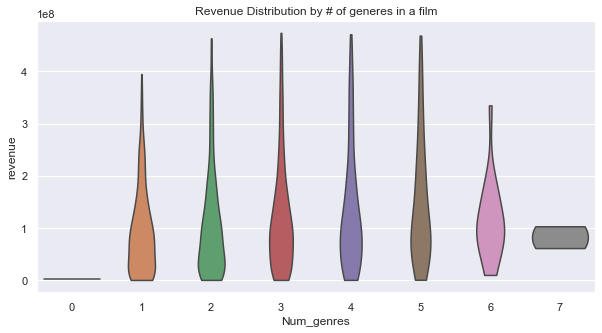

In [5]:
# It seems that the number of genres in a film could be a good way to divide up the films for modeling
plt.figure(figsize=(10,5))
sns.violinplot(x='Num_genres', y='revenue', data=Genres, inner=None, cut=0)
plt.title('Revenue Distribution by # of generes in a film');

It doesn't appear that the number of genres presents a good opportunity to model revenue based off of revenue performance.  I'm going to take a look at the distribution of revenue among different genres.  In order to do so I need to engineer a new data frame from the 'Genres' one that is compatible with seaborn violin plots.  The idea to set revenue as the data frame index, then reset the index in order to accomplishe this came from this [stack overflow](https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas) questions.  

I've plotted the results in a violin plot below. 

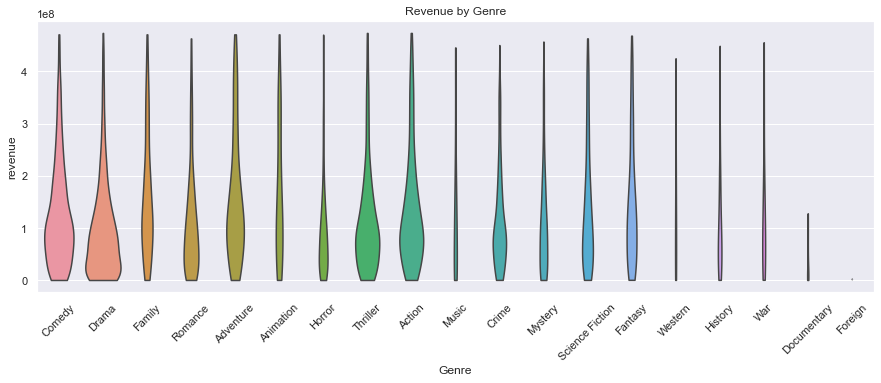

In [6]:
g = Genres.drop('Num_genres', axis=1)
g.set_index('revenue', inplace=True)
g = g[g==1].stack().reset_index().drop(0, axis=1)
plt.figure(figsize=(15,5))
sns.violinplot(x='level_1', y='revenue', data=g, scale='count', inner=None, cut=0)
plt.title('Revenue by Genre')
plt.xticks(rotation=45)
plt.xlabel('Genre');

There are some interesting things that go on with the revenue distribution for Drama and Comedy, however based on this plot it doesn't seem that genres will be a good way to 'tier' films for different models.

### Modeling revenue by year

It was fairly clear in the initial exploratory analysis that there was an overall rise in film revenue as time has progressed. I want to take a look at what the revenue distributions look like as a result of that. 

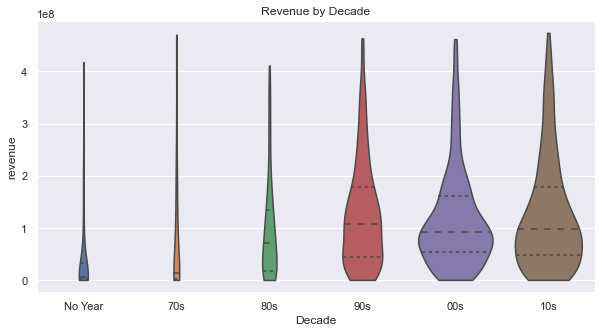

In [7]:
year = box.Release_year
rev = pd.DataFrame(box['Numerical', 'revenue'])
rev.columns = rev.columns.droplevel()
year = year.join(rev)
year.set_index('revenue', inplace=True)
year = year[year == 1].stack().reset_index().drop(0, axis=1)
plt.figure(figsize=(10,5))
sns.violinplot(x='level_1', y='revenue', data=year, scale='count', inner='quartile', cut=0, 
               order=['No Year', '70s', '80s', '90s', '00s', '10s'])
plt.xlabel('Decade')
plt.title('Revenue by Decade');

In [8]:
box.Release_year.value_counts()

No Year  70s  80s  90s  00s  10s
0        0    0    0    1    0      784
                        0    1      705
                   1    0    0      420
              1    0    0    0      151
1        0    0    0    0    0       95
0        1    0    0    0    0       61
dtype: int64

It does seem that using decades to divide this dataset in order to more accurately model revenue would produce different results, since the distribution of film revenue has clear differences from decade to decade.  If successful this could prove valuable since modeling future performance would be based on the most recent decade

### Modelling revenue by seasonality

Another option for modelling revenue is to do so by month or seasonality.  I'll need to group this data into seasons in order to see if either present stronger options than just by decade. 

I suspect that seasonality may need to be grouped differently depending on how revenue performance varies month to month. 

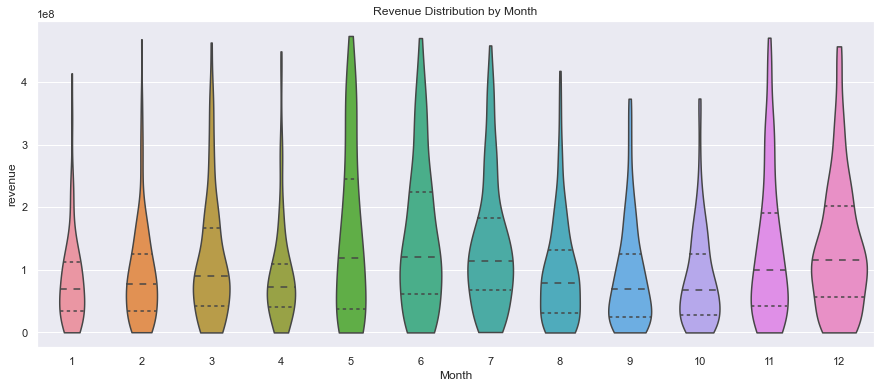

In [9]:
month = box.Release_month
rev = pd.DataFrame(box['Numerical', 'revenue'])
rev.columns = rev.columns.droplevel()
month = month.join(rev)
month.set_index('revenue', inplace=True)
month = month[month==1].stack().reset_index().drop(0, axis=1)
month = month.sort_values('level_1')
plt.figure(figsize=(15,6))
sns.violinplot(x='level_1', y='revenue', data=month, scale='count', inner='quartile', 
              order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], cut=0)
plt.title('Revenue Distribution by Month')
plt.xlabel('Month');

There are two potential ways that I can segment the film data into tiers: using months to create new 'seasons' that don't follow the normal quarterly business convention, and grouping films into decades and modelling everything prior to 1990 as a single group.  

Based on the revenue distribution clearly grouping films into traditional 3 month seasons will group months who's film revenue isn't similar to theirs (April's revenue looks nothing like May or June's, and July's revenue is similarly different from August & September).  Below I'm going to segment this data set into groupings based on seasons that make more sense and keep months who's revenue appears similar together while also 

In [10]:
month = box['Release_month']
Early_season = ['1', '2', '3', '4']
Summer = ['5', '6', '7']
Late_summer = ['8', '9', '10']
Holiday = ['11', '12']
for i in Early_season:
    for k in box.index:
        if box.loc[k,('Release_month', i)] == 1:
            box.loc[k, ('Release_month', 'Season')] = 'Early_season'
for i in Summer:
    for k in box.index:
        if box.loc[k, ('Release_month', i)] == 1:
            box.loc[k, ('Release_month', 'Season')] = 'Summer'
for i in Late_summer:
    for k in box.index:
        if box.loc[k, ('Release_month', i)] == 1:
            box.loc[k, ('Release_month', 'Season')] = 'Late_summer'
for i in Holiday:
    for k in box.index:
        if box.loc[k, ('Release_month', i)] == 1:
            box.loc[k, ('Release_month', 'Season')]= 'Holiday'

In [11]:
box = box.drop(['1', '2', '3', '4','5', '6', '7','8', '9', '10','11', '12'], level=1, axis=1)

In [12]:
# Creating 4 new data frames, one for each season
Early_season = box[box['Release_month', 'Season']=='Early_season']
Early_season = Early_season.drop('Season', level=1, axis=1)
Summer = box[box['Release_month', 'Season']=='Summer']
Summer = Summer.drop('Season', level=1, axis=1)
Late_summer = box[box['Release_month', 'Season']=='Late_summer']
Late_summer = Late_summer.drop('Season', level=1, axis=1)
Holiday = box[box['Release_month', 'Season']=='Holiday']
Holiday = Holiday.drop('Season', level=1, axis=1)
print('Jan-Apr ("Early season") mean revenue: ', round(Early_season['Numerical', 'revenue'].mean(), 2))
print('May-July ("Summer") mean revenue: ', round(Summer['Numerical', 'revenue'].mean(), 2))
print('Aug-Oct ("Late summer") mean revenue: ', round(Late_summer['Numerical', 'revenue'].mean(), 2))
print('Nov/Dec ("Holiday") mean revenue: ', round(Holiday['Numerical', 'revenue'].mean(), 2))

Jan-Apr ("Early season") mean revenue:  97947094.22
May-July ("Summer") mean revenue:  147500704.08
Aug-Oct ("Late summer") mean revenue:  91153258.12
Nov/Dec ("Holiday") mean revenue:  135466007.18


Based on these initial divisions or 'tiers' it seems that there is a clear division between the different seasons that I've identified.  This should in theory result in models that are better performing than those that are trained on the entire data set.

## Modelling using the seasonal tiers

What I want to do here is two things:

1 - First I want to train a new random forest regressor for each season, and assess if this is a more accurate way to model film revenue.  In my previous notebook comparing KNN, GradientBoosting, and Random Forest regressors the random forest regressor performed best (after optimizing hyperparameters with a randomized search) with a RMSE score of $2.45 and an R-squared score of 0.58.  Both scores were the best of any model that was trained.  

2 - Second, I want to compare the top 5 features for each season by using the impurity-based feature importances provided by the random forest regression class in scikit-learn.   This will help provide additional interpretability to stakeholders in this instance. 

In [30]:
# function to calculate mean absolute percentage error
# Due to ongoing issues with package management I am unable to update scikit-learn to 0.24 where the mean absolute percentage
# error function is included for use. 
def MAPE(true, pred):
    MAPE = np.sum(np.abs((true-pred)/true))/len(true)
    return MAPE

#### Early-Season model & scores

In [25]:
# Train/Test split for Early Season
y = np.log(Early_season['Numerical', 'revenue'])
X = Early_season.drop('revenue', axis=1, level=1)
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I've commented out the RandomizedSearchCV portion of these notebooks after getting the best parameters for each model and instantiating a model that fits those hyper parameters.

In [29]:
params = {'n_estimators': np.arange(10,1000), 'min_samples_leaf': np.arange(1,10), 'min_samples_split': np.arange(2,10), 
          'max_depth':np.arange(10,90)}
#rand = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=100)
#rand.fit(X_train, y_train)
#rf_best_score = rand.best_score_
#rf_best_params = rand.best_params_
#print(rf_best_score)
#print(rf_best_params)

In [26]:
RF_ES = RandomForestRegressor(n_estimators=153, min_samples_split=2, min_samples_leaf=4, max_depth=47)
RF_ES.fit(X_train, y_train)
ES_preds = RF_ES.predict(X_test)
ES_r2 = r2_score(y_test, ES_preds)
ES_RMSE = np.exp(mean_squared_error(y_test, ES_preds, squared=False))
ES_MAPE = MAPE(y_test, ES_preds)
ES_MAE = np.exp(mean_absolute_error(y_test, ES_preds))
ES_residuals = y_test-ES_preds
Early_season_scores = {"R2": ES_r2, 'RMSE':ES_RMSE, 'MAPE':ES_MAPE, 'MAE':ES_MAE}
print(Early_season_scores)

{'R2': 0.46887349252082855, 'RMSE': 3.1583363436805745, 'MAPE': 0.04731258124962247, 'MAE': 2.1261450129719606}


I needed to look up the best method for creating a new data frame or array to store the feature wrights of each feature for comparative analysis across season releases.  [This](https://stackoverflow.com/questions/17710672/create-2-dimensional-array-with-2-one-dimensional-array) stackoverflow answer got me pointed in the right direction.

In [32]:
# Extracting the feature weights and sorting by weight
ES_feat_weight = RF_ES.feature_importances_
cols = X.droplevel(0, axis=1)
cols = np.array(list(cols.columns))
ES_weights = np.vstack((cols, ES_feat_weight))
ES_weights = pd.DataFrame(ES_weights)
ES_weights = ES_weights.T
ES_weights[1] = ES_weights[1].astype(float)
ES_weights = ES_weights.sort_values(1, ascending=False)
ES_weights = ES_weights.head(10)
ES_weights.rename(columns={0:'Feature', 1:'Weight'}, inplace=True)

#### Summer season model & scores

In [27]:
# Train/Test split for Summer
y = np.log(Summer['Numerical', 'revenue'])
X = Summer.drop('revenue', axis=1, level=1)
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
params = {'n_estimators': np.arange(10,1000), 'min_samples_leaf': np.arange(1,10), 'min_samples_split': np.arange(2,10), 
          'max_depth':np.arange(10,90)}
# Iterating only 60 times - DS friend told me 100 iterations was overkill and 60 would give about as good an answer
#rand = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=60)
#rand.fit(X_train, y_train)
#rf_best_score = rand.best_score_
#rf_best_params = rand.best_params_
#print(rf_best_score)
#print(rf_best_params)

In [28]:
RF_S = RandomForestRegressor(n_estimators=970, min_samples_split=2, min_samples_leaf=3, max_depth=22)
RF_S.fit(X_train, y_train)
S_preds = RF_S.predict(X_test)
S_r2 = r2_score(y_test, S_preds)
S_RMSE = np.exp(mean_squared_error(y_test, S_preds, squared=False))
S_MAPE = MAPE(y_test, S_preds)
S_MAE = np.exp(mean_absolute_error(y_test, S_preds))
S_residuals = y_test-S_preds
Summer_scores = {"R2": S_r2, 'RMSE':S_RMSE, 'MAPE':S_MAPE, 'MAE':S_MAE}
print(Summer_scores)

{'R2': 0.6509566179476166, 'RMSE': 2.7555644524340406, 'MAPE': 0.040848395152220884, 'MAE': 1.9501095288070114}


In [35]:
S_feat_weight = RF_S.feature_importances_
cols = X.droplevel(0, axis=1)
cols = np.array(list(cols.columns))
S_weights = np.vstack((cols, S_feat_weight))
S_weights = pd.DataFrame(S_weights)
S_weights = S_weights.T
S_weights[1] = S_weights[1].astype(float)
S_weights = S_weights.sort_values(1, ascending=False)
S_weights = S_weights.head(10)
S_weights.rename(columns={0:'Feature', 1:'Weight'}, inplace=True)

#### Late Summer season model & scores

In [36]:
# Train/Test split for Late Summer
y = np.log(Late_summer['Numerical', 'revenue'])
X = Late_summer.drop('revenue', axis=1, level=1)
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
params = {'n_estimators': np.arange(10,1000), 'min_samples_leaf': np.arange(1,10), 'min_samples_split': np.arange(2,10), 
          'max_depth':np.arange(10,90)}
#rand = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=100)
#rand.fit(X_train, y_train)
#rf_best_score = rand.best_score_
#rf_best_params = rand.best_params_
#print(rf_best_score)
#print(rf_best_params)

In [38]:
RF_LS = RandomForestRegressor(n_estimators=998, min_samples_split=3, min_samples_leaf=1, max_depth=27)
RF_LS.fit(X_train, y_train)
LS_preds = RF_LS.predict(X_test)
LS_r2 = r2_score(y_test, LS_preds)
LS_RMSE = np.exp(mean_squared_error(y_test, LS_preds, squared=False))
LS_MAPE = MAPE(y_test, LS_preds)
LS_MAE = np.exp(mean_absolute_error(y_test, LS_preds))
LS_residuals = y_test-LS_preds
Late_summer_scores = {"R2": LS_r2, 'RMSE':LS_RMSE, 'MAPE':LS_MAPE, 'MAE':LS_MAE}
print(Late_summer_scores)

{'R2': 0.5272616066612138, 'RMSE': 3.4188379088879417, 'MAPE': 0.05251698050750999, 'MAE': 2.2677359227342384}


In [40]:
LS_feat_weight = RF_LS.feature_importances_
cols = X.droplevel(0, axis=1)
cols = np.array(list(cols.columns))
LS_weights = np.vstack((cols, LS_feat_weight))
LS_weights = pd.DataFrame(LS_weights)
LS_weights = LS_weights.T
LS_weights[1] = LS_weights[1].astype(float)
LS_weights = LS_weights.sort_values(1, ascending=False)
LS_weights = LS_weights.head(10)
LS_weights.rename(columns={0:'Feature', 1:'Weight'}, inplace=True)

#### Holiday season model & scores

In [41]:
# Train/Test split for the Holiday Season
y = np.log(Holiday['Numerical', 'revenue'])
X = Holiday.drop('revenue', axis=1, level=1)
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
params = {'n_estimators': np.arange(10,1000), 'min_samples_leaf': np.arange(1,10), 'min_samples_split': np.arange(2,10), 
          'max_depth':np.arange(10,90)}
#rand = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=100)
#rand.fit(X_train, y_train)
#rf_best_score = rand.best_score_
#rf_best_params = rand.best_params_
#print(rf_best_score)
#print(rf_best_params)

In [45]:
RFH = RandomForestRegressor(n_estimators=463, min_samples_split=4, min_samples_leaf=5, max_depth=58)
RFH.fit(X_train, y_train)
H_preds = RFH.predict(X_test)
H_r2 = r2_score(y_test, H_preds)
H_RMSE = np.exp(mean_squared_error(y_test, H_preds, squared=False))
H_MAPE = MAPE(y_test, H_preds)
H_MAE = np.exp(mean_absolute_error(y_test, H_preds))
H_residuals = y_test - H_preds
Holiday_scores = {"R2": H_r2, 'RMSE':H_RMSE, 'MAPE':H_MAPE, 'MAE':H_MAE}
print(Holiday_scores)

{'R2': 0.5258623776492359, 'RMSE': 2.7360099547387926, 'MAPE': 0.038029191606334015, 'MAE': 1.8836530956593798}


In [44]:
H_feat_weight = RFH.feature_importances_
cols = X.droplevel(0, axis=1)
cols = np.array(list(cols.columns))
H_weights = np.vstack((cols, H_feat_weight))
H_weights = pd.DataFrame(H_weights)
H_weights = H_weights.T
H_weights[1] = H_weights[1].astype(float)
H_weights = H_weights.sort_values(1, ascending=False)
H_weights = H_weights.head(10)
H_weights.rename(columns={0:'Feature', 1:'Weight'}, inplace=True)

# Comparative analysis between Seasons

In [69]:
Scores = {'Early_season':Early_season_scores, 'Summer':Summer_scores, 'Late_summer':Late_summer_scores, 'Holiday':Holiday_scores}
Scores = pd.DataFrame(Scores)
Scores = Scores.T
Scores.loc['Early_season', 'Mean Revenue'] = round(Early_season['Numerical', 'revenue'].mean(), 2)
Scores.loc['Summer', 'Mean Revenue'] = round(Summer['Numerical', 'revenue'].mean(), 2)
Scores.loc['Late_summer', 'Mean Revenue'] = round(Late_summer['Numerical', 'revenue'].mean(), 2)
Scores.loc['Holiday', 'Mean Revenue'] = round(Holiday['Numerical', 'revenue'].mean(), 2)
Scores['MAPE'] = Scores['MAPE'] * 100
Scores = Scores.round(decimals=4)
Scores

,R2,RMSE,MAPE,MAE,Mean Revenue
Early_season,0.4689,3.1583,4.7313,2.1261,97947094.2200
Summer,0.6510,2.7556,4.0848,1.9501,147500704.0800
Late_summer,0.5273,3.4188,5.2517,2.2677,91153258.1200
Holiday,0.5259,2.7360,3.8029,1.8837,135466007.1800


After converting the Mean Absolute Percentage Error metrics into more readable percentages it appears that the models perform exceptionally well.  When I first set out to begin modelling the data set that I have, the result was and average of over 1,000% error for a linear regression model.  It appears that random forest models are significantly better at predicting revenue for this data, imparting a valuable lesson when it comes to model selection and training: Try multiple models ***early*** and evaluate their performance.  Hyperparameter tuning has improved scores marginally here. 

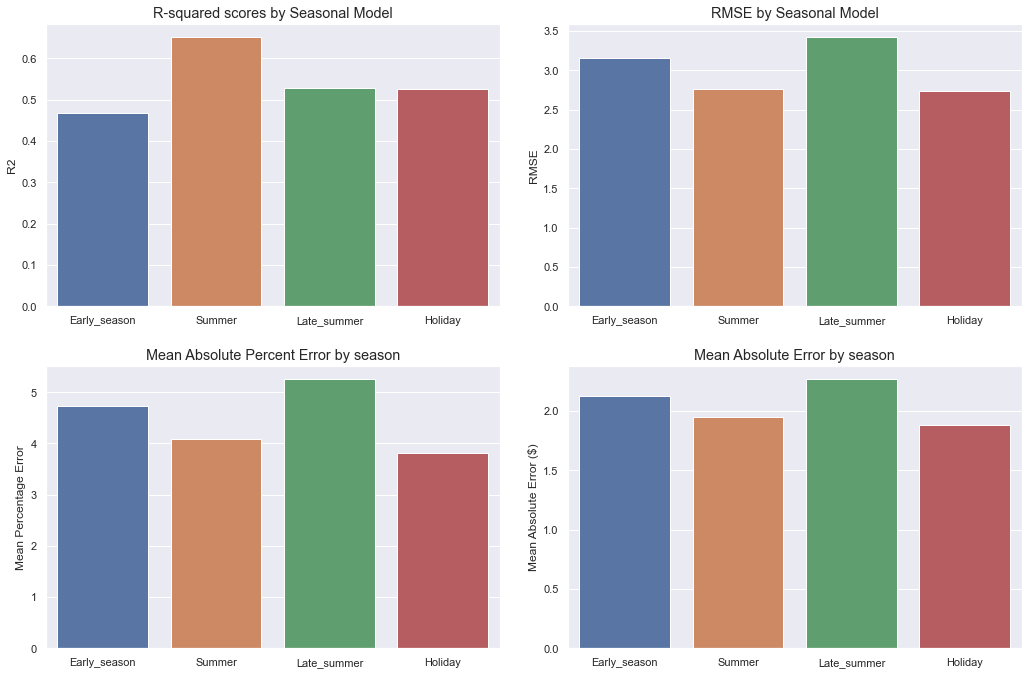

In [68]:
models = list(Scores.index)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 10))
fig.figure
fig.tight_layout(pad=3.0)
sns.barplot(ax=ax1, x=models, y=Scores.R2)
ax1.set_title('R-squared scores by Seasonal Model', size='large')
sns.barplot(ax=ax2, x=models, y=Scores.RMSE)
ax2.set_title('RMSE by Seasonal Model', size='large')
sns.barplot(ax=ax3, x=models, y=Scores.MAPE)
ax3.set_title('Mean Absolute Percent Error by season', size='large')
ax3.set_ylabel('Mean Percentage Error')
sns.barplot(ax=ax4, x=models, y=Scores.MAE)
ax4.set_title('Mean Absolute Error by season', size='large')
ax4.set_ylabel('Mean Absolute Error ($)');

Clearly while Summer & Holiday blockbusters drive up revenue, it is easier for a decision-tree based model to predict that revenue.  What is most surprising is that the season with the highest revenue also has the most variance in price that is able to be explained by the data at hand.  

The relationship between RMSE and mean revenue is interesting as well.  That they seem to be negatively correlated would suggest that, in general, random forest regression models tend to overpredict a films revenue.

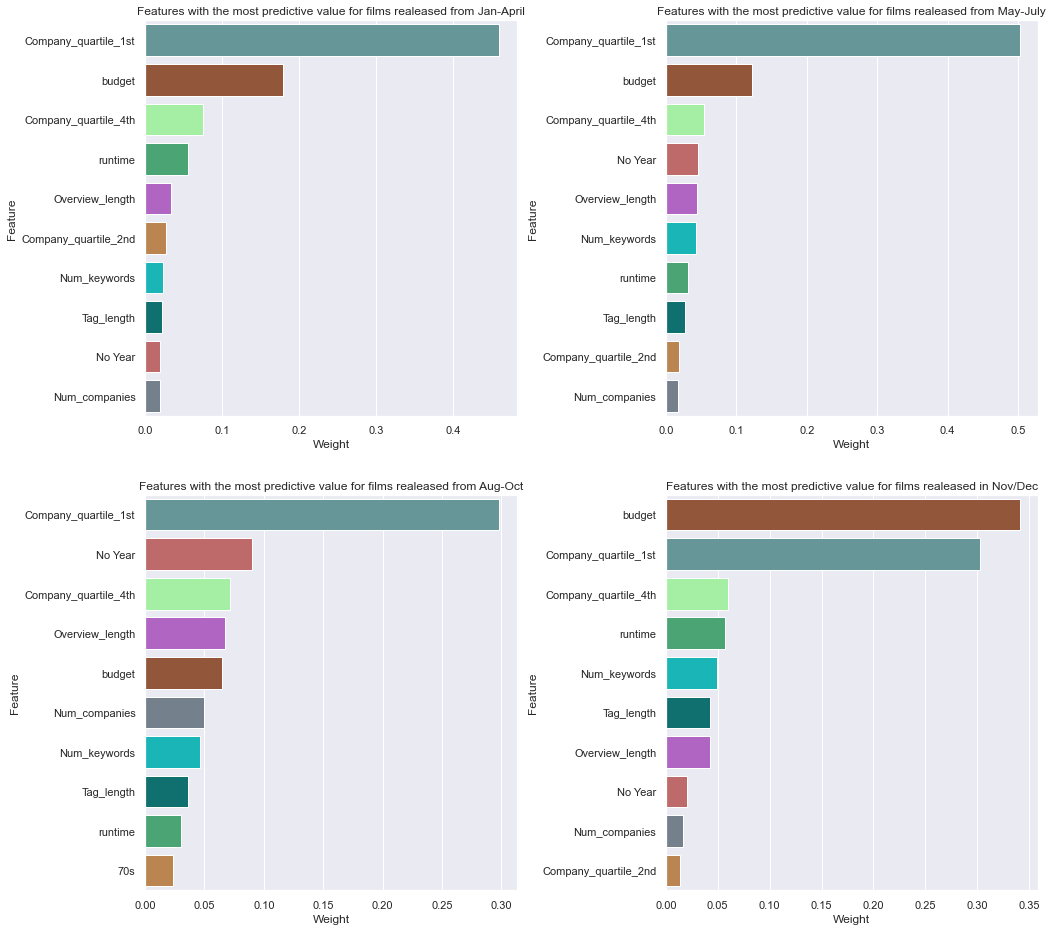

In [84]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 16))
fig.figure
colors = {'Company_quartile_1st':'cadetblue', 'budget':'sienna', 'Company_quartile_4th':'palegreen', 
          'runtime':'mediumseagreen', 'Overview_length':'mediumorchid', 'Company_quartile_2nd':'peru', 
          'Num_keywords':'darkturquoise', 'Tag_length':'teal', 'No Year':'indianred', 'Num_companies':'slategrey', '70s':'peru'}
plt.subplots_adjust(wspace=0.4)
sns.barplot(ax = ax1, x='Weight', y='Feature', data=ES_weights, orient='h', palette=colors)
ax1.set_title('Features with the most predictive value for films realeased from Jan-April')
sns.barplot(ax = ax2, x='Weight', y='Feature', data=S_weights, orient='h', palette=colors)
ax2.set_title('Features with the most predictive value for films realeased from May-July')
sns.barplot(ax = ax3, x='Weight', y='Feature', data=LS_weights, orient='h', palette=colors)
ax3.set_title('Features with the most predictive value for films realeased from Aug-Oct')
sns.barplot(ax = ax4, x='Weight', y='Feature', data=H_weights, orient='h', palette=colors)
ax4.set_title('Features with the most predictive value for films realeased in Nov/Dec');

There are some interesting findings from the most predictive features for each season.  Somewhat unsurprisingly for predicting revenue, whether or not a film is being worked on by a company that is in the top 25% of revenue producing film companies is a strong predictor for the value of a film.  What is surprising is that the most predictive feature for the two highest-revenue seasons (Summer & Holiday) is different.  For Summer films, whether or not a top tier company is working on a film is almost 5 times as important to predicting revenue as the next most important feature.  However for Holiday blockbusters, a film's budget is more important than which companies are working on a given film, although companies are the 2nd and 3rd most important features. 

# Conclusion

At this time the main question for this project has been answered:  I am capable of predicting film revenue with a relatively high degree of accuracy.  

More importantly for imagined stakeholders, the model that best predicts revenue is highly interpretable.  Depending on specific questions after an initial presentation myself or someone else could follow this work and draw conclusions about what most influences the price of a film for a given season, decade, genre, company, etc. This could be used to help stakeholders make informed decisions not only about whether or not a film will have high returns based on the features is has when presented to them, but also about what they can do moving forward to influce the revenue of a film towards teh outcome that is preferred. 

In [74]:
pal = sns.color_palette()
print(pal.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']
